<a href="https://colab.research.google.com/github/Nichanan670510741/Nichanan/blob/main/Lab02_Data_Preprocessing_670510741.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# For Fashion-MNIST
from tensorflow.keras.datasets import fashion_mnist

# For 20 Newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Part 1: Marketing Campaign Dataset - Manual Data Preprocessing & Logistic Regression

### Load the Marketing Campaign Dataset ([Data Information](https://archive.ics.uci.edu/dataset/222/bank+marketing))

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (`'yes'`) or not (`'no'`) subscribed.

In [ ]:
bank_url = 'https://raw.githubusercontent.com/donlap/ds352-labs/main/bank.csv'

df = pd.read_csv(bank_url, sep=';', na_values=['unknown'])
df = df.drop(["emp.var.rate", "cons.price.idx", "cons.conf.idx",	"euribor3m", "nr.employed"], axis=1)
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (41188, 16)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,no


### Data Exploration

In [ ]:
print("--- Missing Values Count ---")
print(df.isnull().sum())

--- Missing Values Count ---
age               0
job             330
marital          80
education      1731
default        8597
housing         990
loan            990
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
y                 0
dtype: int64


In [ ]:
print("--- Unique Values for Categorical Columns ---")
for col in df.select_dtypes(include='object').columns:
    print(f"\n'{col}' unique values:")
    print(df[col].value_counts(dropna=False)) # Include NaN counts

--- Unique Values for Categorical Columns ---

'job' unique values:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
NaN                330
Name: count, dtype: int64

'marital' unique values:
marital
married     24928
single      11568
divorced     4612
NaN            80
Name: count, dtype: int64

'education' unique values:
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
NaN                     1731
illiterate                18
Name: count, dtype: int64

'default' unique values:
default
no     32588
NaN     8597
yes        3
Name: count, dtype: int64

'housing' unique values:
housing
yes    21576
no     18622
NaN      990
Name: count, dtype: int64


### Data Preprocessing

In [ ]:
# Map target variable 'y' to 0 (no) and 1 (yes)
df['y'] = df['y'].map({'no': 0, 'yes': 1})


# Drop 'duration' due to data leakage
df = df.drop('duration', axis=1)

# Define features (X) and target (y)
X = df.drop('y', axis=1)
y = df['y']

# Split the data BEFORE any transformations
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Print data shape
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (32950, 14)
X_test: (8238, 14)
y_train: (32950,)
y_test: (8238,)


We will apply `StandardScaler()`, `OrdinalEncoder()`, and `OneHotEncoder()` on a few selected columns.

**1. Numerical Feature: `age` and `campaign` (Standard Scaling)**

In [ ]:
from sklearn.preprocessing import StandardScaler


num_cols_demo = ['age', 'campaign']

scaler = StandardScaler()

scaler.fit(X_train[num_cols_demo])

# train and test
X_train_scaled = scaler.transform(X_train[num_cols_demo])
X_test_scaled = scaler.transform(X_test[num_cols_demo])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols_demo, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=num_cols_demo, index=X_test.index)

print("Scaled training data:")
print(X_train_scaled.head())

print("\nScaled test data:")
print(X_test_scaled.head())


Scaled training data:
            age  campaign
25611  0.863739  0.522981
26010 -0.289722 -0.203688
40194  3.651268 -0.567023
297   -0.385843 -0.203688
36344  1.824956 -0.203688

Scaled test data:
            age  campaign
14455 -0.770330  0.886316
36380 -0.289722 -0.567023
40076  3.170659 -0.203688
10778  0.383130 -0.203688
27939 -1.154817 -0.203688


**2. Ordinal Feature: `education` (Ordinal Encoding with Imputation)**

- **Imputation**

In [ ]:
## Write your code here
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

ord_col_demo = ['education']

# Impute
imputer_ord = SimpleImputer(strategy='most_frequent')
X_train_ord = imputer_ord.fit_transform(X_train[ord_col_demo])
X_test_ord = imputer_ord.transform(X_test[ord_col_demo])

# Ordinal Encode
encoder_ord = OrdinalEncoder(categories=[[
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y',
    'high.school', 'professional.course', 'university.degree'
]])
X_train_ord = encoder_ord.fit_transform(X_train_ord)
X_test_ord = encoder_ord.transform(X_test_ord)




- **Ordinal Encoding**

In [ ]:
education_categories = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'masters', 'doctorate'
]

In [ ]:
# Impute missing values first
imputer_ord = SimpleImputer(strategy='most_frequent')
X_train_ord = imputer_ord.fit_transform(X_train[['education']])
X_test_ord  = imputer_ord.transform(X_test[['education']])


ordinal_encoder = OrdinalEncoder(categories=[education_categories])

## Write your code here
X_train_ord = ordinal_encoder.fit_transform(X_train_ord)
X_test_ord  = ordinal_encoder.transform(X_test_ord)


**3. Nominal Feature: `job` (One-Hot Encoding with Imputation)**

- **Imputation**

In [ ]:
nom_col_demo = ['job']

imputer_nom = SimpleImputer(strategy='most_frequent')
imputer_nom.fit(X_train[nom_col_demo])

X_train_imputed_nom_demo = imputer_nom.transform(X_train[nom_col_demo])
X_test_imputed_nom_demo = imputer_nom.transform(X_test[nom_col_demo])

- **Nominal Encoding**

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Nominal column
nom_col_demo = ['job']

# Imputation
imputer_nom = SimpleImputer(strategy='most_frequent')
X_train_imputed_nom = imputer_nom.fit_transform(X_train[nom_col_demo])
X_test_imputed_nom  = imputer_nom.transform(X_test[nom_col_demo])



onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

## Write your code here
X_train_nom_enc = onehot_encoder.fit_transform(X_train_imputed_nom)
X_test_nom_enc  = onehot_encoder.transform(X_test_imputed_nom)

X_train_nom_enc = pd.DataFrame(X_train_nom_enc, columns=onehot_encoder.get_feature_names_out(nom_col_demo), index=X_train.index)
X_test_nom_enc  = pd.DataFrame(X_test_nom_enc, columns=onehot_encoder.get_feature_names_out(nom_col_demo), index=X_test.index)

print("One-Hot Encoded training data (job):")
print(X_train_nom_enc.head())




One-Hot Encoded training data (job):
       job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  job_management  job_retired  job_self-employed  job_services  job_student  job_technician  job_unemployed
25611         0.0              1.0               0.0            0.0             0.0          0.0                0.0           0.0          0.0             0.0             0.0
26010         0.0              0.0               1.0            0.0             0.0          0.0                0.0           0.0          0.0             0.0             0.0
40194         0.0              0.0               0.0            0.0             0.0          1.0                0.0           0.0          0.0             0.0             0.0
297           1.0              0.0               0.0            0.0             0.0          0.0                0.0           0.0          0.0             0.0             0.0
36344         0.0              0.0               0.0            0.0             0.0     

### **Exercise 1: Apply All Preprocessing & Train Logistic Regression**

Now, it's your turn to apply these preprocessing steps to *all* relevant columns and then train a Logistic Regression model.

**Instructions:**

1.  Look at the Variable Table in [this link](https://archive.ics.uci.edu/dataset/222/bank+marketing).
2. Make lists for `numerical_features`, `ordinal_features`, and `nominal_features`.
3. Preprocess the features. It is safer to make a copy of `X_train` using:
   ```
   X_train_copy = X_train.copy()
   X_test_copy = X_test.copy()
   ```
   and preprocess `X_train_copy` instead.

   **For nominal features, concat the one-hot encoded features using [`pd.concat(..., axis=1)`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) and drop the old nominal features from the dataframe.**
4. Train Logistic Regression on the preprocessed `X_train_copy` and `y_train`.
5. Evaluate the Model:
    *   Make predictions on the preprocessed `X_test_copy`.
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?


In [ ]:
print(X_train.columns)


Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome'], dtype='object')


In [ ]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

# Convert column names to string (IMPORTANT fix)
X_train_copy.columns = X_train_copy.columns.astype(str)
X_test_copy.columns  = X_test_copy.columns.astype(str)

# Define groups
numerical_features = ['age', 'campaign', 'pdays', 'previous']
ordinal_features   = ['education']
nominal_features   = [
    'job', 'marital', 'default', 'housing',
    'loan', 'contact', 'month', 'day_of_week', 'poutcome'
]

# Scale numerical
scaler = StandardScaler()
X_train_copy[numerical_features] = scaler.fit_transform(X_train_copy[numerical_features])
X_test_copy[numerical_features]  = scaler.transform(X_test_copy[numerical_features])

# Ordinal encode
education_categories = [
    'illiterate','basic.4y','basic.6y','basic.9y',
    'high.school','professional.course',
    'university.degree','masters','doctorate'
]

from sklearn.impute import SimpleImputer
imputer_ord = SimpleImputer(strategy='most_frequent')

X_train_edu = imputer_ord.fit_transform(X_train_copy[['education']])
X_test_edu  = imputer_ord.transform(X_test_copy[['education']])

ord_enc = OrdinalEncoder(
    categories=[education_categories],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

X_train_copy['education'] = ord_enc.fit_transform(X_train_edu)
X_test_copy['education']  = ord_enc.transform(X_test_edu)

# One-hot encode nominal features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

train_ohe = pd.DataFrame(
    ohe.fit_transform(X_train_copy[nominal_features]),
    index=X_train_copy.index
)

test_ohe = pd.DataFrame(
    ohe.transform(X_test_copy[nominal_features]),
    index=X_test_copy.index
)

train_ohe.columns = train_ohe.columns.astype(str)
test_ohe.columns  = test_ohe.columns.astype(str)

# Replace original nominal columns
X_train_copy = pd.concat([X_train_copy.drop(columns=nominal_features), train_ohe], axis=1)
X_test_copy  = pd.concat([X_test_copy.drop(columns=nominal_features),  test_ohe], axis=1)

# Train model
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_copy, y_train)

# Report
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test_copy)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.69      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.80      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238



## Part 2: Fashion-MNIST Dataset - Image Classification

### Load Fashion-MNIST Dataset

The Fashion-MNIST dataset consists of 28x28 grayscale images of fashion items.

In [ ]:
(fm_X_train, fm_y_train), (fm_X_test, fm_y_test) = fashion_mnist.load_data()

print(f"Fashion-MNIST Train data shape: {fm_X_train.shape}")
print(f"Fashion-MNIST Train labels shape: {fm_y_train.shape}")
print(f"Fashion-MNIST Test data shape: {fm_X_test.shape}")
print(f"Fashion-MNIST Test labels shape: {fm_y_test.shape}")

Fashion-MNIST Train data shape: (60000, 28, 28)
Fashion-MNIST Train labels shape: (60000,)
Fashion-MNIST Test data shape: (10000, 28, 28)
Fashion-MNIST Test labels shape: (10000,)


In [ ]:
print(f"First image {fm_X_train[0]}")
print(f"First label {fm_y_train[0]}")

First image [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   

### Visualize Fashion-MNIST Images

Let's see what these images look like.

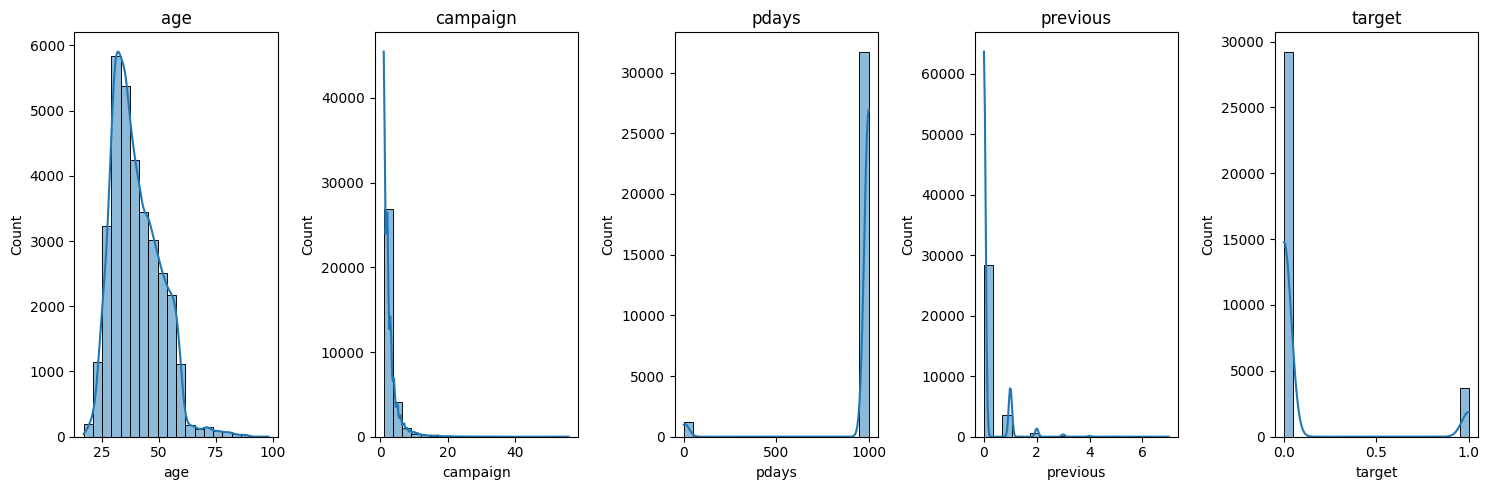

/tmp/ipython-input-1219262021.py:41: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


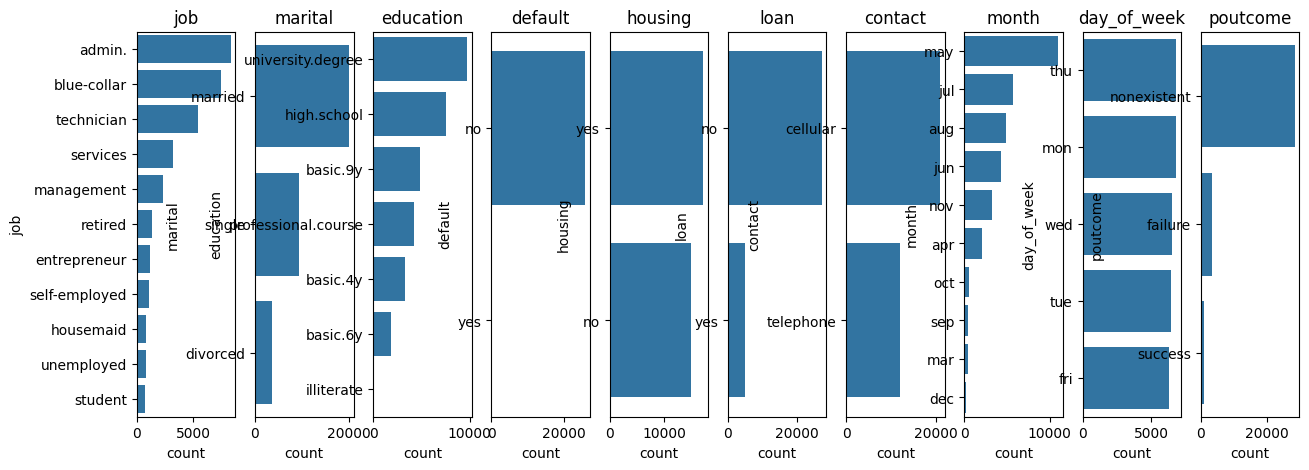

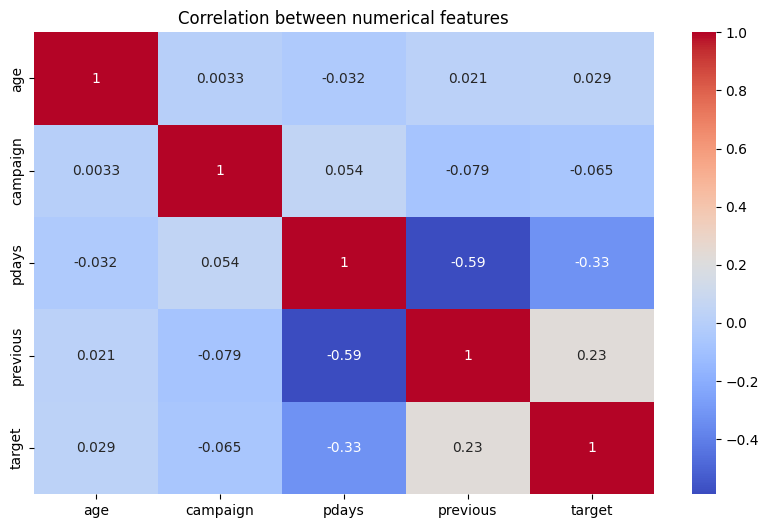

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fashion_mnist_class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Visualize the images
## Write your code here


# Copy data
df = X_train.copy()
df['target'] = y_train

# ------------------------
# 1) Numerical Features
# ------------------------
numerical_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

plt.figure(figsize=(15,5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i+1)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()

# ------------------------
# 2) Categorical Features
# ------------------------
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

plt.figure(figsize=(15,5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, len(categorical_cols), i+1)
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(col)
plt.tight_layout()
plt.show()

# ------------------------
# 3) Correlation Heatmap (Numerical)
# ------------------------
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between numerical features")
plt.show()


### **Exercise 2: Preprocessing Images (Flatten and Scale)**

Images are 2D arrays (matrices of pixels) and pixel values are integers from 0-255. For Logistic Regression, we need:
*  **Flattening:** Convert each 28x28 image into a 1D array of 784 features.
*  **Scaling:** Normalize pixel values from [0, 255] to [0, 1].

**Instructions:**

1.   **Flatten:** Use the `.reshape()` method (see [documentation](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html)). For `fm_X_train_binary` (shape `(num_samples, 28, 28)`), you want to reshape it to `(num_samples, 28*28)`.
2.  **Scale:** Divide the flattened pixel values by 255.0 to get values between 0 and 1.
3.   **Train Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
    *   Fit the model on your *processed* `fm_X_train_scaled` and `fm_y_train`.
4.   **Make Predictions:** Use `predict()` to make predictions on the *processed* `fm_X_test_scaled`.
5.   **Print Classification Report:** Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?
6.   **Visualize Misclassifications:**
    *   Find the indices in `fm_X_test_binary` where your model made incorrect predictions (i.e., `fm_y_pred != fm_y_test`).
    *   Select 5 of these misclassified images.
    *   Plot these images (using `plt.imshow`). For each image, print its true label and its predicted label.

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype(np.int8)

# แบ่งเป็น train/test
from sklearn.model_selection import train_test_split
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# reshape ให้เป็น 28x28 (สำหรับ visualization)
X_train_images = X_train_full.reshape(-1,28,28)
X_test_images = X_test_full.reshape(-1,28,28)

binary_filter_train = (y_train==0) | (y_train==1)
fm_X_train_binary = X_train_images[binary_filter_train]
fm_y_train = y_train[binary_filter_train]

binary_filter_test = (y_test==0) | (y_test==1)
fm_X_test_binary = X_test_images[binary_filter_test]
fm_y_test = y_test[binary_filter_test]


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2778
           1       1.00      1.00      1.00      3159

    accuracy                           1.00      5937
   macro avg       1.00      1.00      1.00      5937
weighted avg       1.00      1.00      1.00      5937

Number of misclassified images: 5


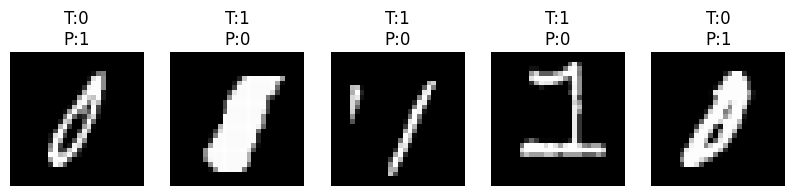

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Flatten the images
num_train = fm_X_train_binary.shape[0]
num_test = fm_X_test_binary.shape[0]

fm_X_train_flat = fm_X_train_binary.reshape(num_train, -1)  # (num_samples, 784)
fm_X_test_flat = fm_X_test_binary.reshape(num_test, -1)

# Scale pixel values to [0,1]
fm_X_train_scaled = fm_X_train_flat / 255.0
fm_X_test_scaled = fm_X_test_flat / 255.0

# Initialize Logistic Regression
model = LogisticRegression(solver='saga', max_iter=1000)

# Train the model
model.fit(fm_X_train_scaled, fm_y_train)

# Make predictions
fm_y_pred = model.predict(fm_X_test_scaled)

# Evaluate the model
print("Classification Report:\n")
print(classification_report(fm_y_test, fm_y_pred))

# Visualize misclassifications
misclassified_idx = np.where(fm_y_pred != fm_y_test)[0]
print(f"Number of misclassified images: {len(misclassified_idx)}")

# เลือก 5 misclassified images แบบสุ่ม
np.random.seed(42)
sample_idx = np.random.choice(misclassified_idx, size=5, replace=False)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(sample_idx):
    plt.subplot(1, 5, i+1)
    plt.imshow(fm_X_test_binary[idx], cmap='gray')
    plt.title(f"T:{fm_y_test[idx]}\nP:{fm_y_pred[idx]}")
    plt.axis('off')
plt.show()


## Part 3: 20 Newsgroups Dataset - Text Classification

### Load 20 Newsgroups Dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics.

In [ ]:
news_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
news_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)

X_train_news, y_train_news = news_train.data, news_train.target
X_test_news, y_test_news = news_test.data, news_test.target

print(f"Number of training documents: {len(X_train_news)}")
print(f"Number of test documents: {len(X_test_news)}")
print(f"Categories: {news_train.target_names}")

Number of training documents: 11314
Number of test documents: 7532
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


### Explore Sample Document

In [ ]:
# Document แรก
first_doc = X_train_news[0]
first_label = y_train_news[0]

print("=== First Document ===")
print(first_doc[:1000])

print("\n=== Label ===")
print(f"{first_label} -> {news_train.target_names[first_label]}")



=== First Document ===
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----






=== Label ===
7 -> rec.autos


### Preprocessing: Text Vectorization Demonstration with `TfidfVectorizer`

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Where:

$$
\text{TF}(t, d) = \frac{\text{number of word }t\text{ in } d}{\text{number of words in } d} \quad \text{ and } \quad
\text{IDF}(t, D) = \log\left(\frac{\text{total number of documents}}{\text{number of documents that contain word }t}\right).
$$

In [ ]:
sample_sentences = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?"
]

vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the sample sentences
sample_vec_output_sparse = vectorizer.fit_transform(sample_sentences)

sample_vec_output_dense = sample_vec_output_sparse.toarray()

print(vectorizer.vocabulary_)
print(vectorizer.get_feature_names_out())
print(sample_vec_output_dense)

{'document': 0, 'second': 1}
['document' 'second']
[[1.         0.        ]
 [0.78722298 0.61666846]
 [0.         0.        ]
 [1.         0.        ]]


### **Exercise 3: Apply TF-IDF Vectorization to Full Dataset**

Now, apply `TfidfVectorizer` to the actual training and testing datasets for the 20 Newsgroups classification task.

**Instructions:**

1.  **Initialize `TfidfVectorizer`:**
    *   Initialize `TfidfVectorizer`. Use `stop_words='english'` to remove common words.
2.  **Fit and Transform Training Data:**
    *   Call `fit_transform()` on `X_train_news` to learn the vocabulary and transform the training text into TF-IDF features. Store the result in `X_train_vec`.
3.  **Transform Test Data:**
    *   Call `transform()` on `X_test_news` using the *already fitted* vectorizer. Store the result in `X_test_vec`. **Crucially, do not call `fit_transform()` on the test data!** This would cause data leakage.
4.  **Initialize Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
5.  **Train the Model:**
    *   Fit the model on your `X_train_vec` and `y_train_news`.
6.  **Make Predictions:**
    *   Make predictions using `predict()` on the `X_test_vec`.
7.  **Evaluate the Model:**
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# 2. Fit and transform training data
X_train_vec = vectorizer.fit_transform(X_train_news)

# 3. Transform test data (DO NOT fit again)
X_test_vec = vectorizer.transform(X_test_news)

# 4. Initialize Logistic Regression
model = LogisticRegression(solver='saga', max_iter=1000)

# 5. Train the model
model.fit(X_train_vec, y_train_news)

# 6. Make predictions
y_pred = model.predict(X_test_vec)

# 7. Evaluate the model
print(classification_report(y_test_news, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.73      0.76       319
           1       0.71      0.80      0.75       389
           2       0.75      0.76      0.75       394
           3       0.70      0.74      0.72       392
           4       0.80      0.83      0.82       385
           5       0.85      0.75      0.79       395
           6       0.78      0.87      0.82       390
           7       0.90      0.89      0.90       396
           8       0.94      0.95      0.94       398
           9       0.88      0.92      0.90       397
          10       0.94      0.96      0.95       399
          11       0.95      0.91      0.93       396
          12       0.75      0.78      0.76       393
          13       0.88      0.86      0.87       396
          14       0.89      0.91      0.90       394
          15       0.81      0.93      0.87       398
          16       0.75      0.90      0.82       364
          17       0.97    